# Домашняя работа №2

#### 1. Самостоятельно разобраться с тем, что такое tfidf

Описываю так, как я это понял. Поправьие меня, пожалуйста, если что-то не так.

Для анализ смысла текста применяются методики частотного скорринга. Они основаны на подсчете количества слов в тексте, например:
1. Простым суммированием, т.е. сколько раз каждое слово встречается в документеи
2. Или подсчитывается, как часто каждое слово встречается в тексте по отношению к общему количеству слов.
 
 Такая методика обоснована, но тут возникает проблема. Часто бывает так, что в текстах наиболее часто встречающеся слова не описывают смысл текста. Смысл кроется в менее часто встречающихся словах. Поэтому требуется оценить значимость слов в тексте.
 
 TF-IDF (сокращение от term frequency — inverse document frequency) – это статистическая мера для оценки важности слова в документе.
 
 TF - отношение числа вхождений слова к общему числу слов документа.
 IDF - это десятичныйлогарифм от боратной величины TF
 
 Следовательно TFIDF=TF*IDF


#### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### Для оценки изменения качества модели за счет модификации функции get_user_embedding, для начала повторим модель, которая была на занятии. 

In [28]:
#импортируем необходимые библиотеки

import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize
from gensim.corpora.dictionary import Dictionary

import pymorphy2  # pip install pymorphy2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
#загружаем Датасет с новостями
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [30]:
#загружаем Датасет с пользователями
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [32]:
#nltk.download('all')

стоп-слова

In [33]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [34]:
with open('stopwords.txt', encoding='utf-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [35]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [36]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 24.9 s


In [37]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 26s


### модель

In [38]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [39]:
#common_dictionary[5]

#### Обучение

In [40]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [41]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [42]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(4, 0.059382528),
 (5, 0.041980024),
 (11, 0.32218325),
 (12, 0.03287517),
 (13, 0.12974472),
 (16, 0.08578909),
 (17, 0.10587797),
 (21, 0.20417608)]

### Какие получились темы

In [43]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: военный операция мозг тело смерть кровь день
topic_1: женщина погибнуть жизнь мужчина армия всё пострадать
topic_2: медведев белоруссия россия законодательство следствие nn рубль
topic_3: россия исследование nn данные сотрудник обнаружить российский
topic_4: сша статья журнал американский рак долг ребёнок
topic_5: исследование станция снижение аэропорт налог ниже зарплата
topic_6: проект рубль правительство строительство министерство территория документ
topic_7: рынок развитие наука риск рост уровень россия
topic_8: фонд пациент пенсия препарат врач реформа остров
topic_9: млн тыс стоимость составить сумма составлять сократиться
topic_10: nn банк россия рубль цена решение писать
topic_11: солнце мальчик выдать способность запустить игра вдвое
topic_12: выяснить убийство иск взрыв следователь подозревать преступление
topic_13: газ первый всё россия новый nn автор
topic_14: ракета технология запуск земля китай японский программа
topic_15: украина nn земля научный россия американ

### функция, которая будет нам возвращать векторное представление новости

In [44]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [45]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.879337,0.000000,0.000000,0.0,0.023625,0.023334,...,0.00000,0.065691,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,4896,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.70086,0.092082,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.000000,0.0,0.0,0.000000,0.058926,0.042039,0.0,0.000000,0.000000,...,0.00000,0.085894,0.106001,0.0,0.0,0.0,0.203582,0.0,0.0,0.0
3,4898,0.046932,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.000000,0.0,0.0,0.903861,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Векторные представления пользователей

In [46]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [47]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [48]:
doc_dict[293627]

array([0.        , 0.        , 0.        , 0.20538941, 0.        ,
       0.        , 0.09004008, 0.        , 0.        , 0.03908248,
       0.44053075, 0.        , 0.18278784, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [49]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [50]:
get_user_embedding(user_articles_list)

array([0.04367641, 0.03756844, 0.1226208 , 0.19522287, 0.05170626,
       0.        , 0.10516961, 0.04721147, 0.00270228, 0.00411092,
       0.02986555, 0.        , 0.04674727, 0.04721183, 0.01426288,
       0.03860912, 0.01967658, 0.02398463, 0.        , 0.        ,
       0.01415144, 0.02920119, 0.11142872, 0.        , 0.00247616])

In [51]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [52]:
" ".join(news[news['doc_id']==323183]['title'].iloc[0])

'владимир путин убрать всё препона мешать россиянин усыновлять сирота краткий срок риа новость nn правительство принять ряд решение отдельный острый проблема пока остаться неурегулированный нужно убрать всё препона мешать гражданин желать принять ребёнок семья путин заседание совет реализация приоритетный национальный проект демографический политика nn федеральный уровень отсутствовать примерный порядок срок подготовка гражданин приём ребёнок семья поручать правительство краткий срок урегулировать всё проблема подчеркнуть путин подписать указ увеличение социальный выплата безработный родитель воспитывать ребёнок подписать указ существенно повышать социальный выплата неработающий родитель воспитывать детейинвалид возраст инвалид детство независимо возраст путин объяснить размер выплата составить тысяча рубль рассчитываться поручить разработать предложение программа материнский капитал перестать действовать мера поддержка семья установленный срок реализация программа материнский капитал 

In [53]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.046106,0.057783,0.023817,0.091109,0.074679,0.010547,0.026438,0.000000,0.006093,...,0.176957,0.000000,0.002795,0.005986,0.023707,0.076963,0.021943,0.025324,0.016092,0.012979
1,u108690,0.015923,0.030977,0.007612,0.175024,0.057650,0.019049,0.024132,0.031908,0.003785,...,0.237206,0.008878,0.024103,0.003843,0.012447,0.040600,0.012315,0.051549,0.005838,0.006890
2,u108339,0.044018,0.076009,0.008684,0.278648,0.055089,0.016765,0.045069,0.016764,0.015214,...,0.080811,0.003485,0.040420,0.008723,0.000000,0.025158,0.008923,0.000000,0.000000,0.013177


### Разметка датасета

In [54]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [55]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.046106,0.057783,0.023817,0.091109,0.074679,0.010547,0.026438,0.000000,0.006093,...,0.000000,0.002795,0.005986,0.023707,0.076963,0.021943,0.025324,0.016092,0.012979,0
1,u108690,0.015923,0.030977,0.007612,0.175024,0.057650,0.019049,0.024132,0.031908,0.003785,...,0.008878,0.024103,0.003843,0.012447,0.040600,0.012315,0.051549,0.005838,0.006890,1
2,u108339,0.044018,0.076009,0.008684,0.278648,0.055089,0.016765,0.045069,0.016764,0.015214,...,0.003485,0.040420,0.008723,0.000000,0.025158,0.008923,0.000000,0.000000,0.013177,1


### Подготавливаем данные

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [57]:
X_test

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
3069,0.032924,0.039025,0.063433,0.173556,0.069728,0.000000,0.045113,0.050433,0.007008,0.005075,...,0.045018,0.000000,0.036053,0.000000,0.020765,0.041050,0.003575,0.030890,0.009699,0.003588
1675,0.061914,0.072458,0.116851,0.047456,0.021037,0.017890,0.072818,0.021171,0.000000,0.065531,...,0.058890,0.006398,0.000000,0.000000,0.140771,0.009344,0.041456,0.007055,0.000000,0.013859
6385,0.034040,0.098344,0.020762,0.149800,0.021735,0.020029,0.025065,0.030164,0.018499,0.006827,...,0.125494,0.001744,0.013401,0.005869,0.005522,0.100605,0.005784,0.020512,0.006489,0.007106
543,0.003027,0.020727,0.022948,0.357157,0.028489,0.011724,0.040949,0.021272,0.002944,0.006101,...,0.095775,0.000000,0.003999,0.009942,0.000000,0.021267,0.010802,0.113202,0.015420,0.004157
3213,0.060451,0.024163,0.064747,0.293299,0.048964,0.040698,0.051361,0.000000,0.000000,0.000000,...,0.060927,0.000000,0.015743,0.000000,0.074708,0.014166,0.000000,0.021848,0.013908,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,0.005568,0.082399,0.047392,0.214215,0.041287,0.000000,0.066043,0.071898,0.026571,0.000000,...,0.137642,0.000000,0.013488,0.000000,0.005285,0.015117,0.000000,0.024235,0.000000,0.000000
2913,0.002321,0.048550,0.042147,0.078131,0.036808,0.000000,0.065808,0.041913,0.000000,0.000000,...,0.055847,0.013017,0.035663,0.000000,0.058266,0.137401,0.058684,0.019506,0.034105,0.011500
6150,0.002750,0.003686,0.065137,0.010153,0.013183,0.000000,0.012581,0.103234,0.005318,0.011061,...,0.020868,0.107946,0.000000,0.000000,0.205967,0.047042,0.000000,0.000000,0.000000,0.000000
7213,0.000000,0.019991,0.081839,0.168305,0.000000,0.000000,0.030162,0.027439,0.028430,0.000000,...,0.069604,0.041253,0.000000,0.026202,0.055567,0.120326,0.004901,0.044074,0.008467,0.009738


In [58]:
X_train

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
286,0.010511,0.072414,0.072596,0.083534,0.007226,0.000000,0.010019,0.023241,0.000000,0.001815,...,0.105938,0.063703,0.000000,0.005897,0.151891,0.066781,0.009523,0.000000,0.023573,0.000000
6696,0.000000,0.015821,0.000000,0.092556,0.053237,0.000000,0.000000,0.071684,0.000000,0.000000,...,0.016140,0.013504,0.010874,0.000000,0.128327,0.056468,0.041550,0.040797,0.020737,0.016415
6486,0.039717,0.014978,0.002683,0.022830,0.011804,0.000000,0.000000,0.106020,0.007799,0.000000,...,0.075884,0.028129,0.008362,0.000000,0.074694,0.081486,0.000000,0.013480,0.000000,0.012433
1145,0.002129,0.004023,0.004171,0.031285,0.009807,0.025164,0.000000,0.078685,0.006710,0.061033,...,0.033862,0.050218,0.045186,0.009916,0.220394,0.040466,0.015805,0.005030,0.000000,0.009728
6346,0.021032,0.033588,0.012165,0.004382,0.014891,0.002222,0.000000,0.113117,0.000000,0.051927,...,0.066033,0.114818,0.000000,0.009984,0.145514,0.063711,0.061180,0.000000,0.000000,0.004270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.045754,0.019539,0.014551,0.168303,0.027239,0.008348,0.034751,0.004998,0.002992,0.000000,...,0.114232,0.004699,0.002970,0.000000,0.053709,0.101486,0.051077,0.020525,0.011399,0.022732
3264,0.103970,0.014361,0.019564,0.035280,0.013419,0.018537,0.000000,0.081006,0.000000,0.000000,...,0.149484,0.077427,0.039368,0.000000,0.007513,0.025964,0.005350,0.004322,0.000000,0.000000
1653,0.018338,0.039341,0.029676,0.239364,0.017562,0.031532,0.058717,0.032984,0.023051,0.021680,...,0.007591,0.000000,0.028506,0.000000,0.005523,0.157222,0.000000,0.021562,0.007493,0.006078
2607,0.099284,0.030024,0.014937,0.003601,0.039738,0.019871,0.000000,0.062706,0.014086,0.020531,...,0.034149,0.009860,0.005611,0.000000,0.032140,0.058355,0.017718,0.005326,0.000000,0.000000


In [59]:
y_test

3069    0
1675    0
6385    1
543     0
3213    0
       ..
3482    0
2913    0
6150    0
7213    0
3262    0
Name: churn, Length: 2000, dtype: int64

In [60]:
y_train

286     0
6696    0
6486    0
1145    0
6346    0
       ..
4931    0
3264    0
1653    0
2607    0
2732    0
Name: churn, Length: 6000, dtype: int64

In [61]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [62]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06907595, 0.02728378, 0.39880502, 0.25505474, 0.07516167,
       0.22261755, 0.1909914 , 0.1460056 , 0.08767046, 0.09052208])

### Рассчитаем Precision, Recall, F_score

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

mean_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Best Threshold=0.226749, F-Score=0.665, Precision=0.585, Recall=0.771


# Метрики у меня  почему-то просели. Меньше тех, которые были получены на занятии. Объяснения почему так случилось у меня нет

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1621  134]
 [  57  188]]


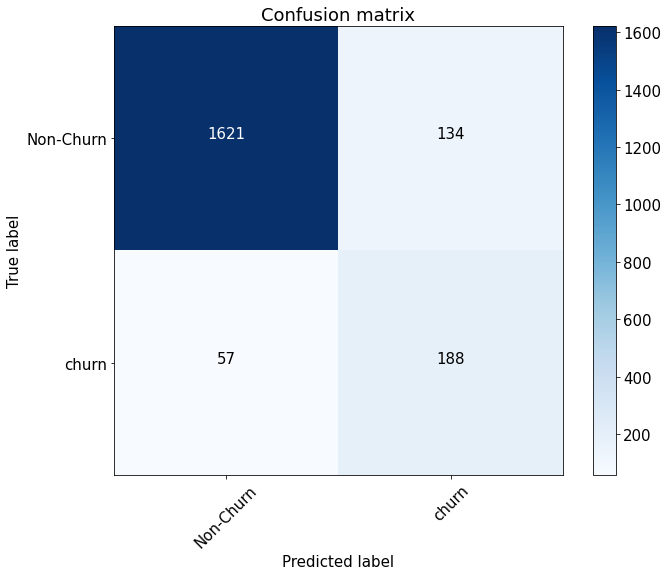

In [65]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [67]:
roc_auc_score(y_test, preds)

0.9441804756090469

Запомним ROC_AUC

#### Модернизируем функцию get_user_embedding 

In [68]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.20621927, 0.0517183 ,
       0.        , 0.07578565, 0.01375887, 0.        , 0.        ,
       0.02200242, 0.        , 0.        , 0.        , 0.        ,
       0.04555398, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11203792, 0.        , 0.        ])

In [70]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

median_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Best Threshold=0.244512, F-Score=0.771, Precision=0.699, Recall=0.861


Confusion matrix, without normalization
[[1664   91]
 [  35  210]]


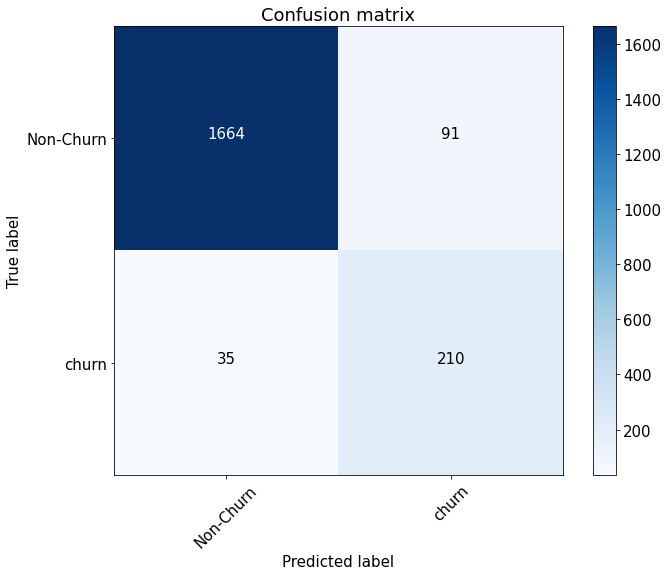

In [71]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [72]:
roc_auc_score(y_test, preds)

0.9757939415082273

Качество модели существенно улучшилось. Как видно из Confusion matrix существенно уменьшились значения False Negative и False Positive, что неплохо

#### 3. Повторить п.2, но используя уже не медиану, а max

In [73]:
user_articles_list = users['articles'].iloc[33]
# print(user_articles_list)

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.max(user_vector, 0)
#     print('\nuser_vector', user_vector)
    return user_vector

get_user_embedding(user_articles_list)

array([0.15037397, 0.20019066, 0.56161183, 0.37683144, 0.10968208,
       0.        , 0.30331859, 0.1812578 , 0.0162137 , 0.02466553,
       0.10463899, 0.        , 0.2804836 , 0.18831196, 0.07096145,
       0.07505371, 0.11805946, 0.07327631, 0.        , 0.        ,
       0.08490866, 0.15340528, 0.27256307, 0.        , 0.01485694])

In [74]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

max_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Best Threshold=0.356698, F-Score=0.836, Precision=0.852, Recall=0.820


In [75]:
fscore[ix]

0.8357588357588358

Confusion matrix, without normalization
[[1720   35]
 [  45  200]]


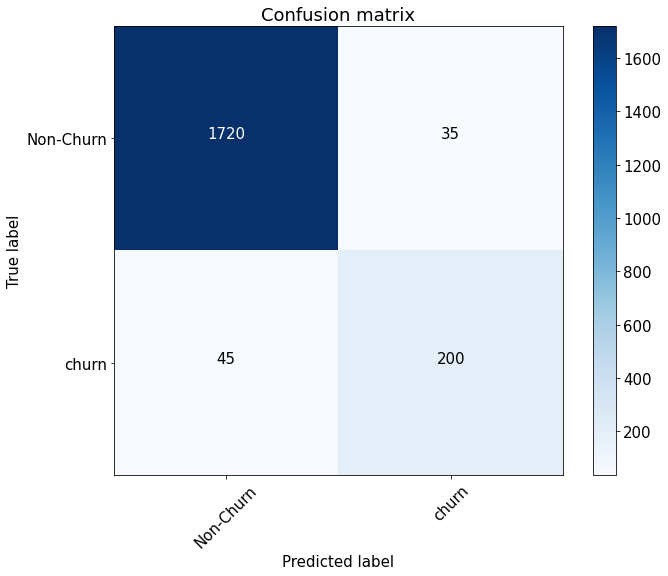

In [78]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [79]:
roc_auc_score(y_test, preds)

0.982398976684691

#### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

Пока не разобрался как это сделать

#### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [81]:
Table = pd.DataFrame({'mean': mean_rating, 'median': median_rating, 'max': max_rating}).T
Table.columns=['f1_score', 'precision', 'recall', 'roc_auc_score']
Table

,f1_score,precision,recall,roc_auc_score
mean,0.665493,0.585139,0.771429,0.944180
median,0.771481,0.698675,0.861224,0.975794
max,0.835759,0.851695,0.820408,0.982399


#### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

По таблице видно, что после замены на медиану или максимум метрики качества модели существенно улучшились. При этом наибольший ROC_AUC и F1_score наблюдается при замене на максимум. Среднее значение показало себя хуже всех.

Если сравнивать медиану и максимум, как видно из Confusion matrix, при использовании максимума существенно уменьшилось значение False Positive, при этом False Negative увеличилось. 

С учетом специки задачи, наиболее предпочительной моделью является 3-й случай с использованием max